In [1]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent.parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"

import sys
sys.path.append(str(DATA.parent))  # Add the parent directory of 'modeling' to the Python path

con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [2]:
import pandas as pd
import numpy as np

df_2016_17 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2016-17'", con)
df_2017_18 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2017-18'", con)
df_2018_19 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2018-19'", con)
df_2019_20 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2019-20'", con)
df_2020_21 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2020-21'", con)
df_2021_22 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2021-22'", con)
df_2022_23 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2022-23'", con)
df_2023_24 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2023-24'", con)

year_df_mapping = {
    2016: df_2016_17,
    2017: df_2017_18,
    2018: df_2018_19,
    2019: df_2019_20,
    2020: df_2020_21,
    2021: df_2021_22,
    2022: df_2022_23,
    2023: df_2023_24,
}
grad_rate_columns_to_drop = [
    col
    for col in df_2016_17.columns
    if col.startswith("RegHSDiploma")
    or col.startswith("Dropout")
    or col.startswith("UniReqs")
]
csu_rate_columns_to_drop = [
    col
    for col in df_2016_17.columns
    if col.startswith("UniReqs") or col.startswith("RegHSDiploma")
]

## XGBoost


### Cross-Validated Grad Rate


<Figure size 1400x600 with 0 Axes>

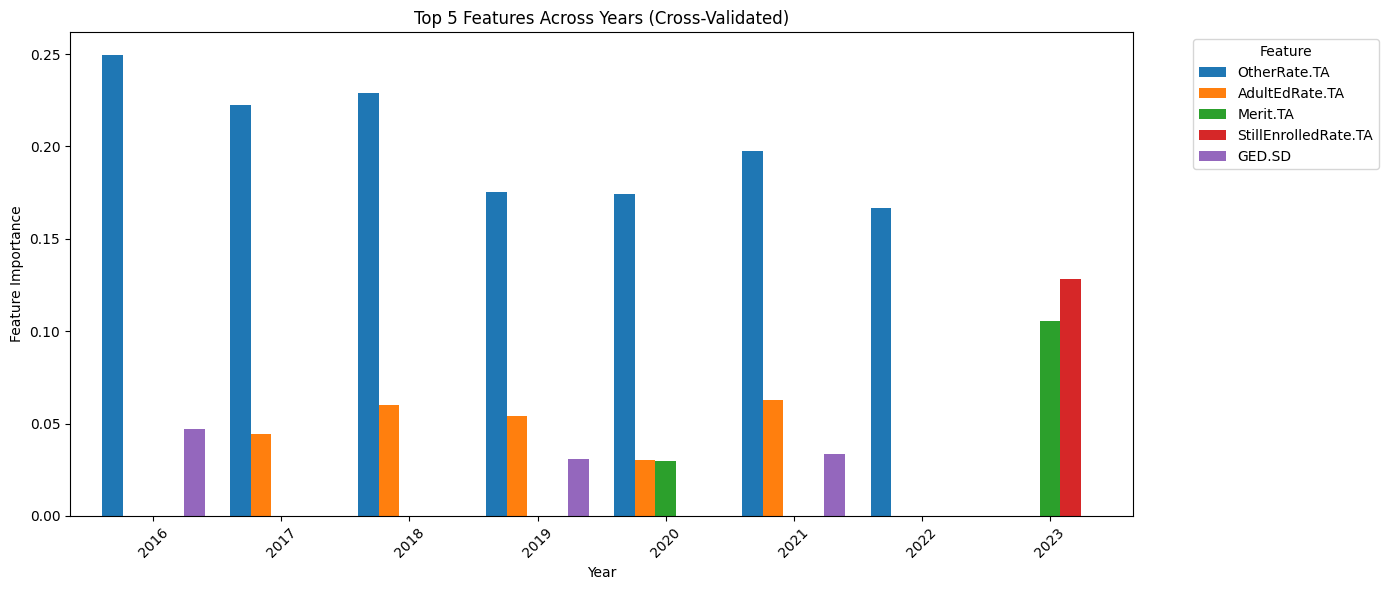

In [3]:
from modeling.utils.xgboost import cross_validate_xgboost, plot_cv_feature_importance
from modeling.utils.xgboost import (
    plot_top_k_features,
    plot_feature_avg_variance,
    plot_feature_time_series,
)

cv_xgb_models = {}

target_column = "RegHSDiplomaRate.TA"

for year, year_df in year_df_mapping.items():

    cv_result = cross_validate_xgboost(
        df=year_df,
        target_column=target_column,
        columns_to_drop=[target_column, "Year"] + grad_rate_columns_to_drop,
        n_splits=5,
        print_results=False,
    )

    cv_xgb_models[year] = cv_result

top_features = plot_cv_feature_importance(cv_xgb_models, top_n=5)

<Figure size 1400x600 with 0 Axes>

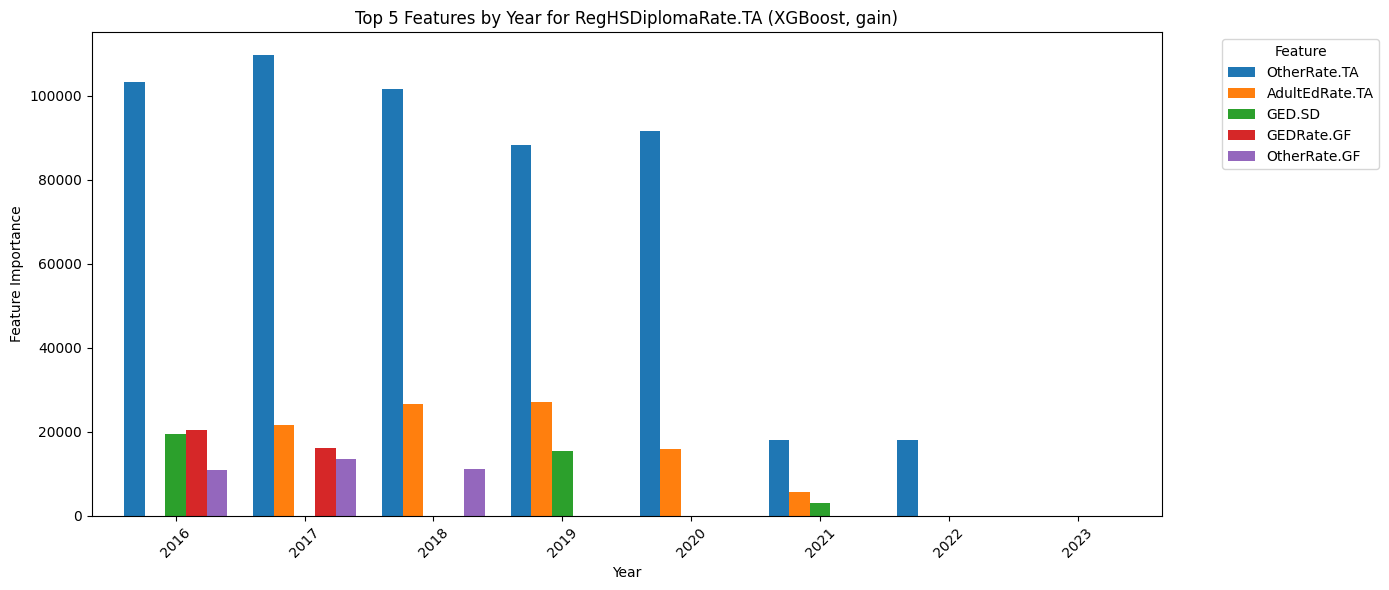

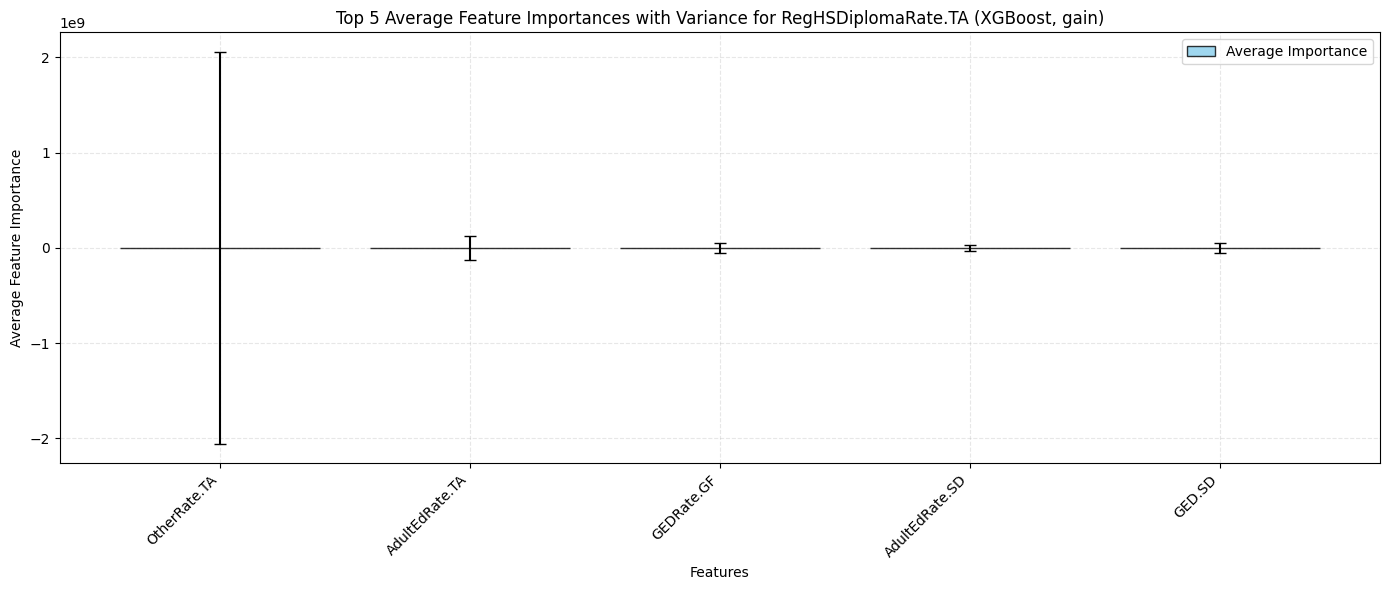

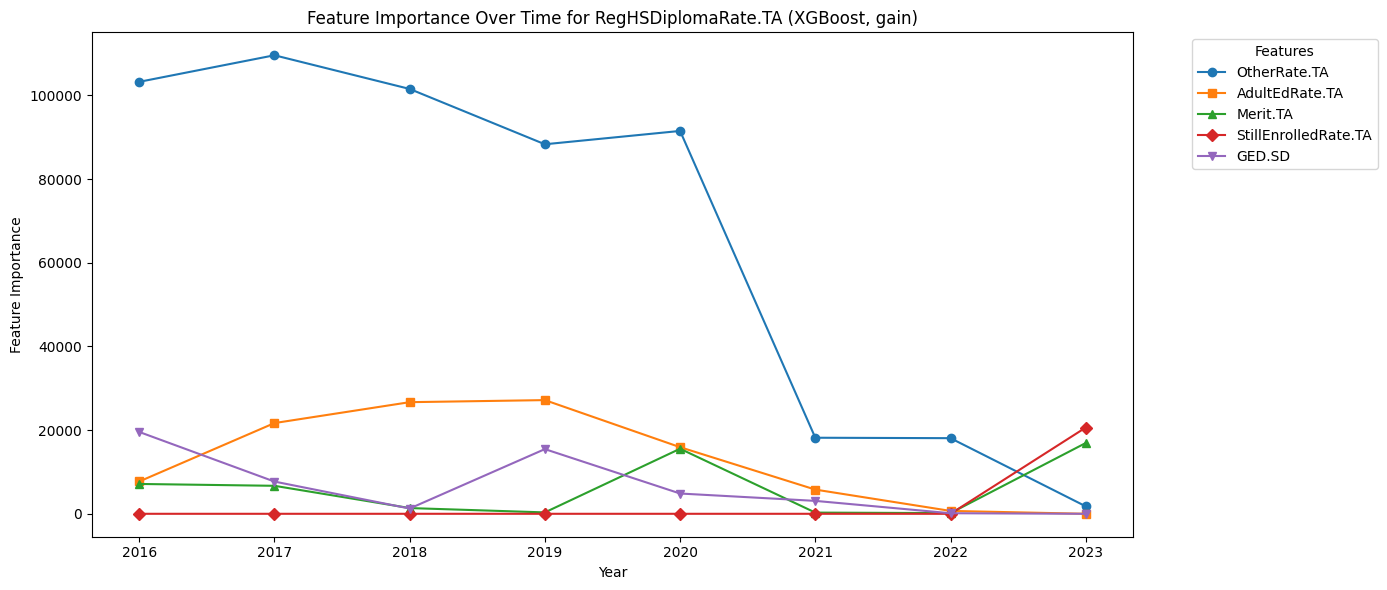

In [4]:
plot_top_k_features(cv_xgb_models, "XGBoost", "gain", target_column, k=5)
plot_feature_avg_variance(cv_xgb_models, "XGBoost", "gain", target_column)
plot_feature_time_series(
    cv_xgb_models, "XGBoost", "gain", target_column, top_features[:5]
)

### Cross-Validated CSU/UC Readiness Rate


<Figure size 1400x600 with 0 Axes>

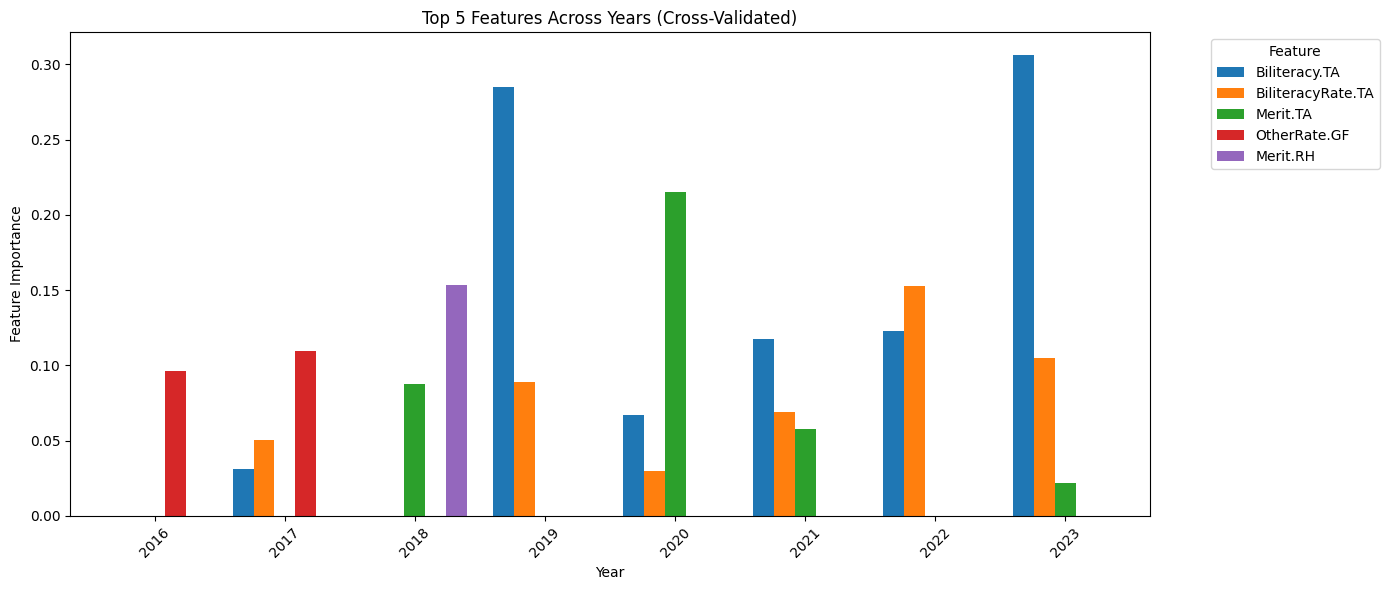

In [ ]:
from modeling.utils.xgboost import cross_validate_xgboost, plot_cv_feature_importance
from modeling.utils.xgboost import (
    plot_top_k_features,
    plot_feature_avg_variance,
    plot_feature_time_series,
)

cv_xgb_models = {}

target_column = "UniReqsPercent.TA"

for year, year_df in year_df_mapping.items():

    cv_result = cross_validate_xgboost(
        df=year_df,
        target_column=target_column,
        columns_to_drop=[target_column, "Year"] + csu_rate_columns_to_drop,
        n_splits=5,
        print_results=False,
    )

    cv_xgb_models[year] = cv_result


<Figure size 1400x600 with 0 Axes>

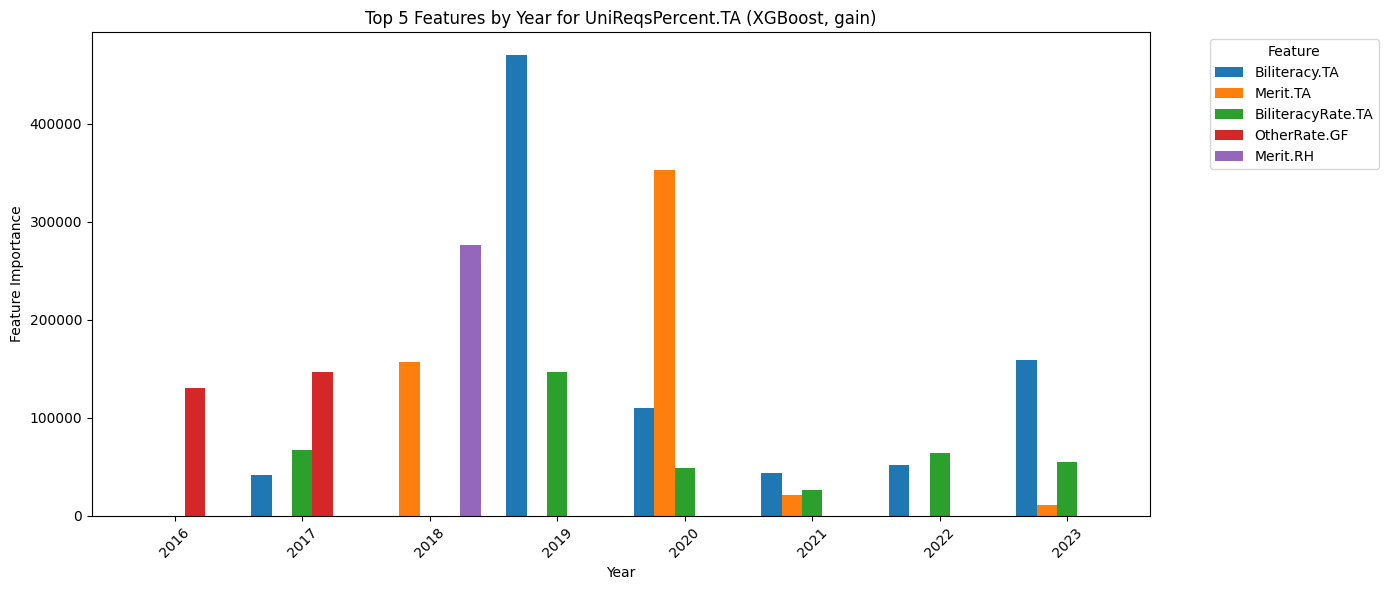

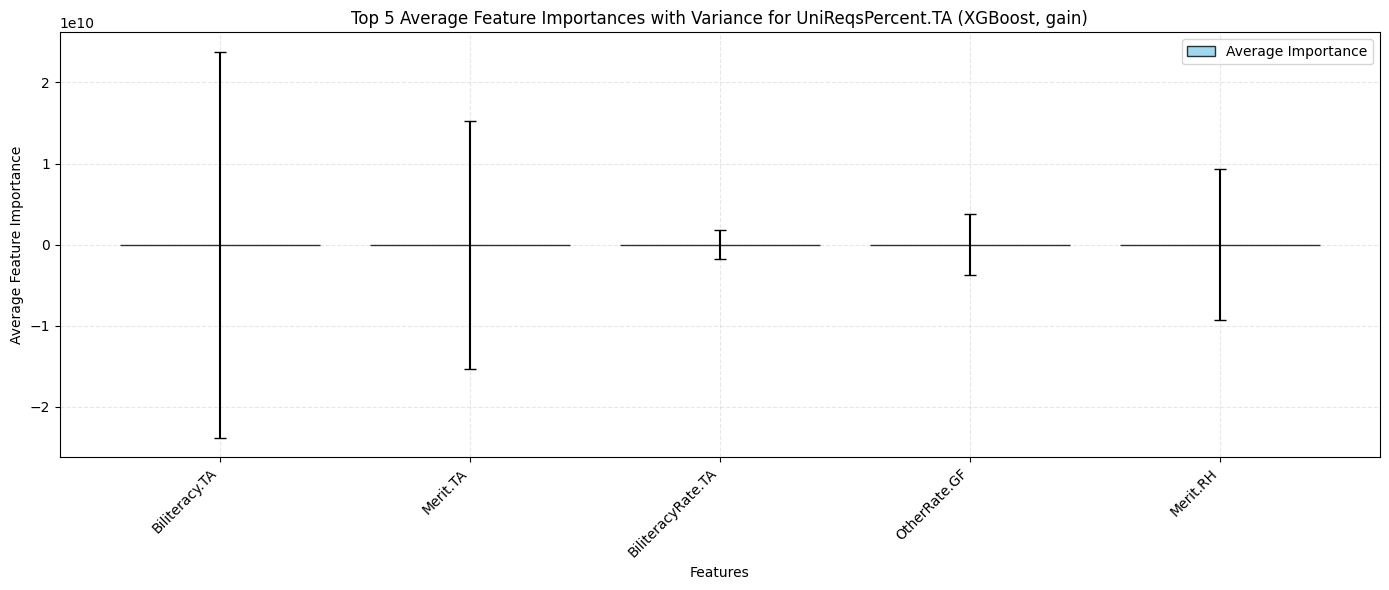

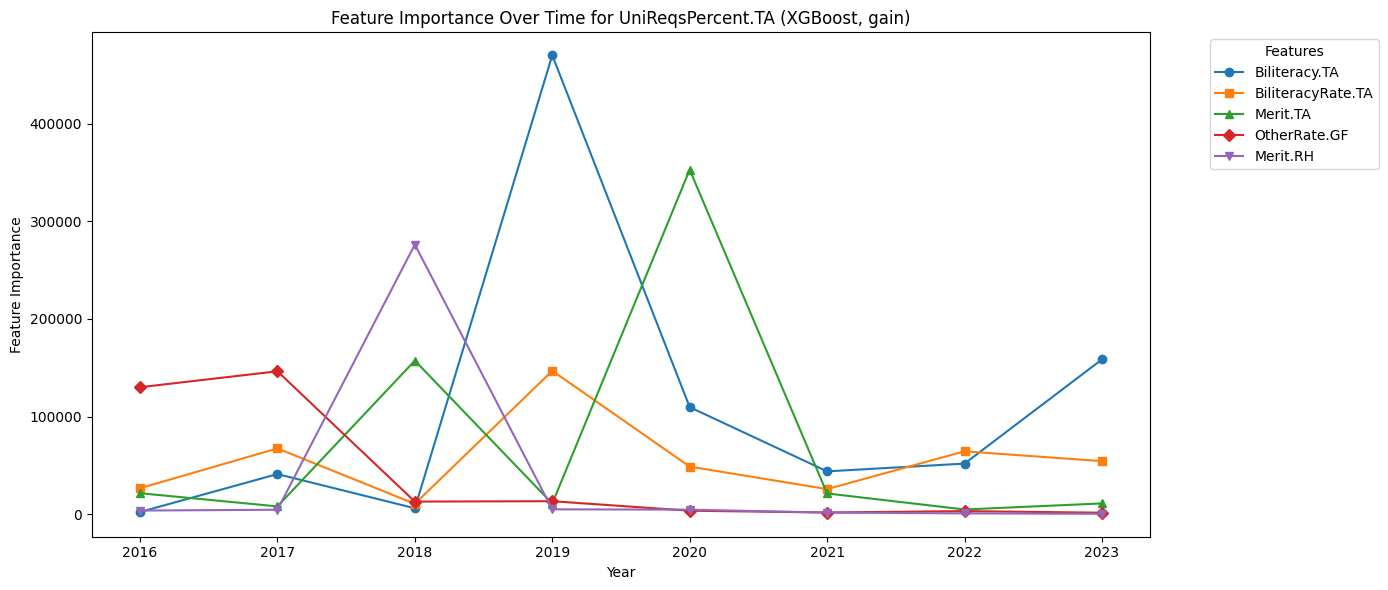

In [ ]:
top_features = plot_cv_feature_importance(cv_xgb_models, top_n=5)
plot_top_k_features(cv_xgb_models, "XGBoost", "gain", target_column, k=5)
plot_feature_avg_variance(cv_xgb_models, "XGBoost", "gain", target_column)
plot_feature_time_series(
    cv_xgb_models, "XGBoost", "gain", target_column, top_features[:5]
)

### Non-Cross Validated Grad Rate


In [7]:
import modeling.utils.xgboost as xgb

grad_rate = "RegHSDiplomaRate.TA"
xgb_model = "XGBoost"

all_grad_rate_models = {}
for year, df in year_df_mapping.items():
    all_grad_rate_models[year] = xgb.train_xgboost_model(
        df, grad_rate, grad_rate_columns_to_drop, print_plot=False
    )

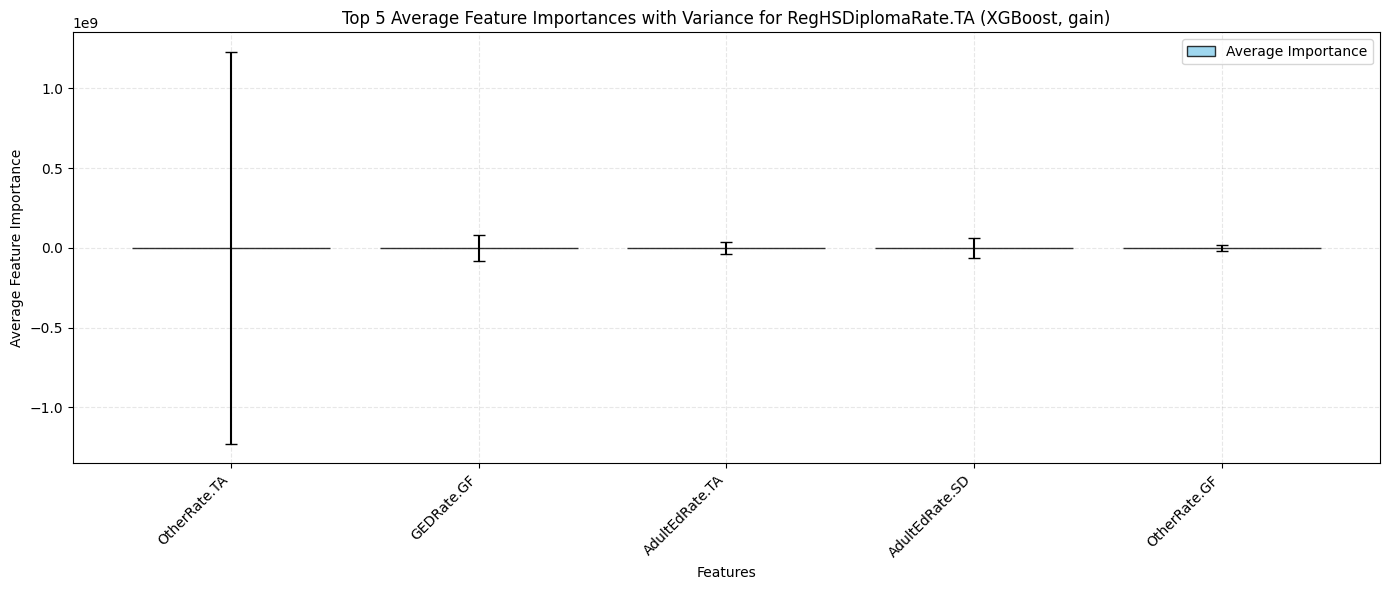

<Figure size 1400x600 with 0 Axes>

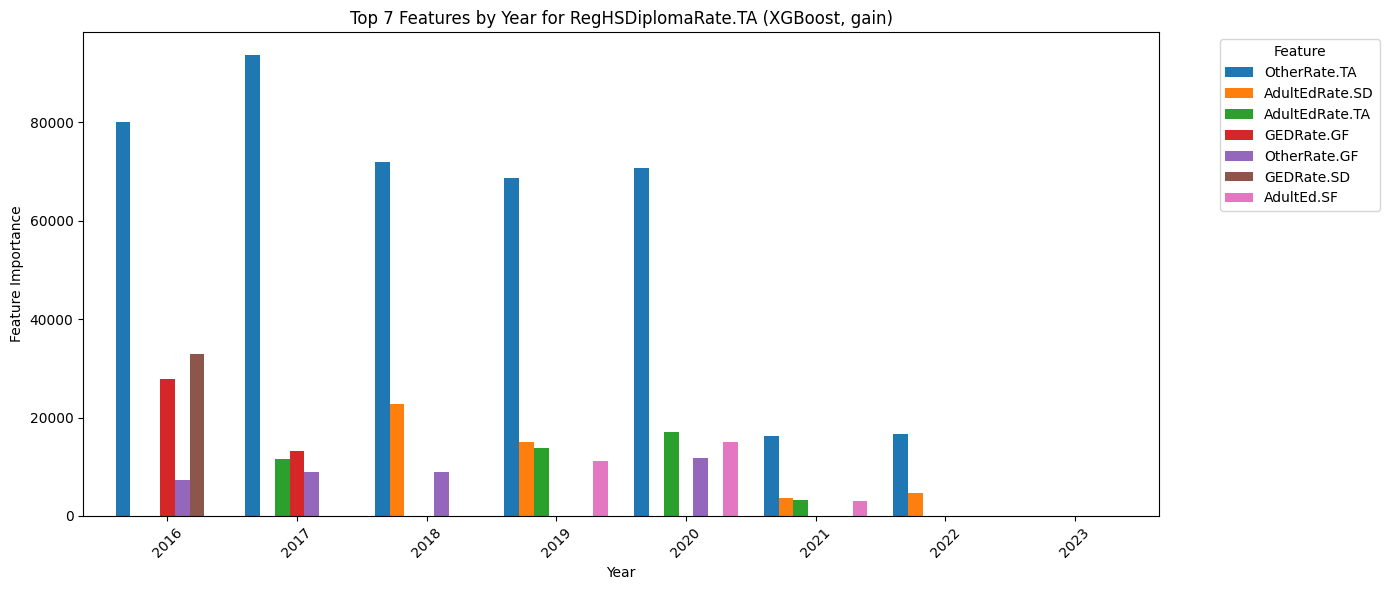

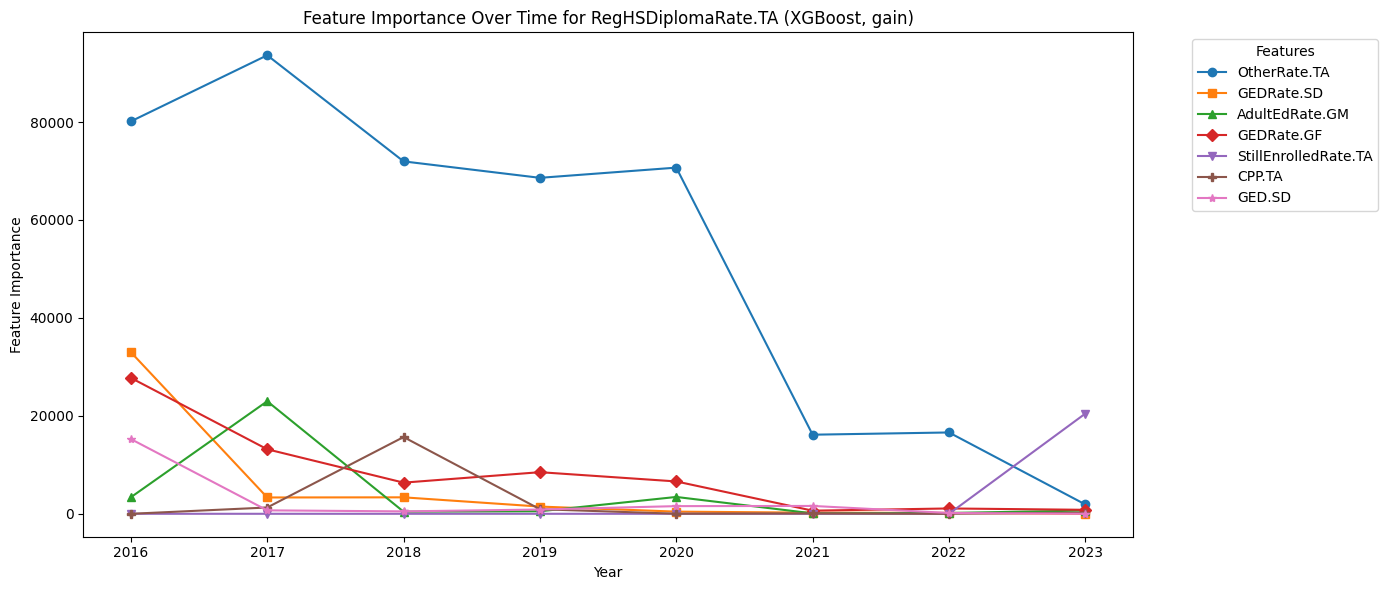

In [8]:
xgb.plot_feature_avg_variance(all_grad_rate_models, xgb_model, "gain", grad_rate, k=5)
top_k_features = xgb.plot_top_k_features(
    all_grad_rate_models, xgb_model, "gain", grad_rate, k=7
)
xgb.plot_feature_time_series(
    all_grad_rate_models, xgb_model, "gain", grad_rate, top_k_features
)

### Non Cross-Validated CSU/UC Readiness Rate


In [9]:
import modeling.utils.xgboost as xgb

uc_csu_rate = "UniReqsPercent.TA"
xgb_model = "XGBoost"

all_csu_rate_models = {}
for year, df in year_df_mapping.items():
    all_csu_rate_models[year] = xgb.train_xgboost_model(
        df, grad_rate, csu_rate_columns_to_drop, print_plot=False
    )

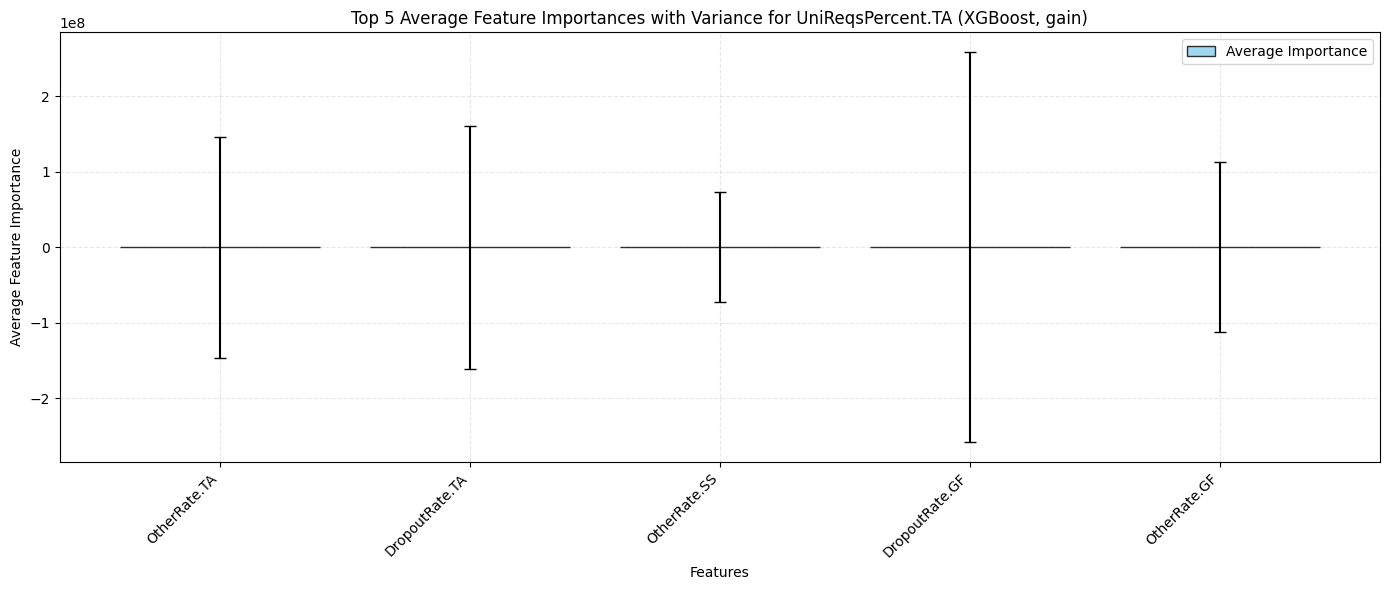

<Figure size 1400x600 with 0 Axes>

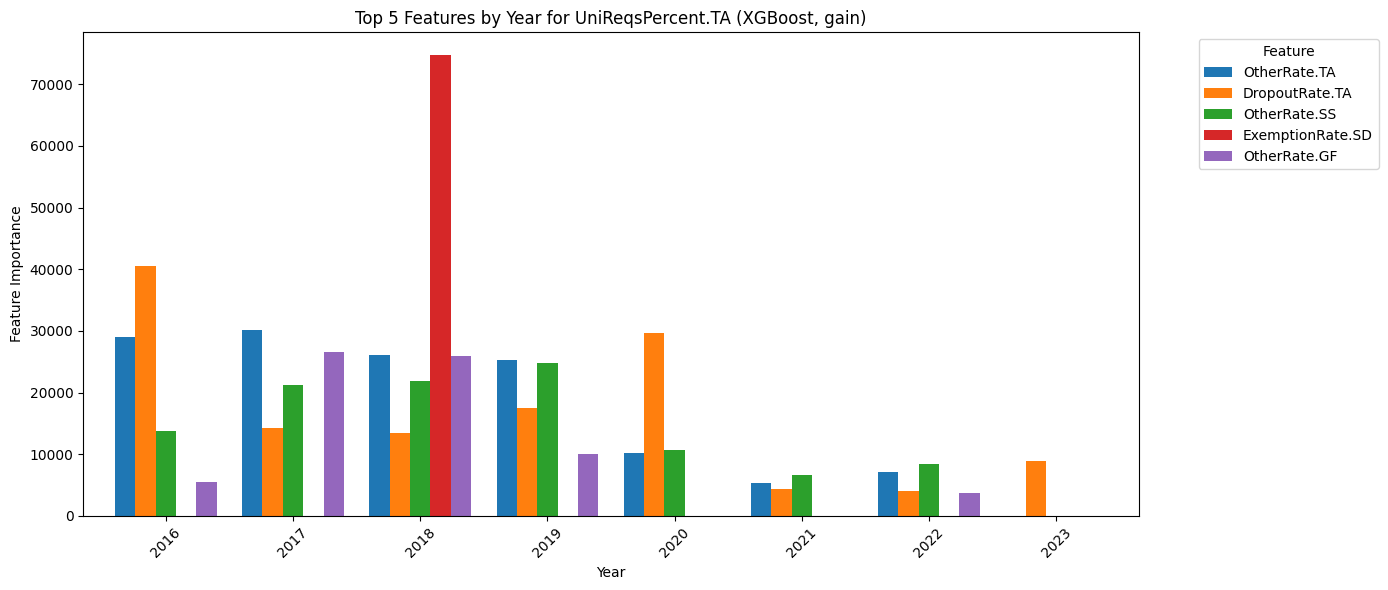

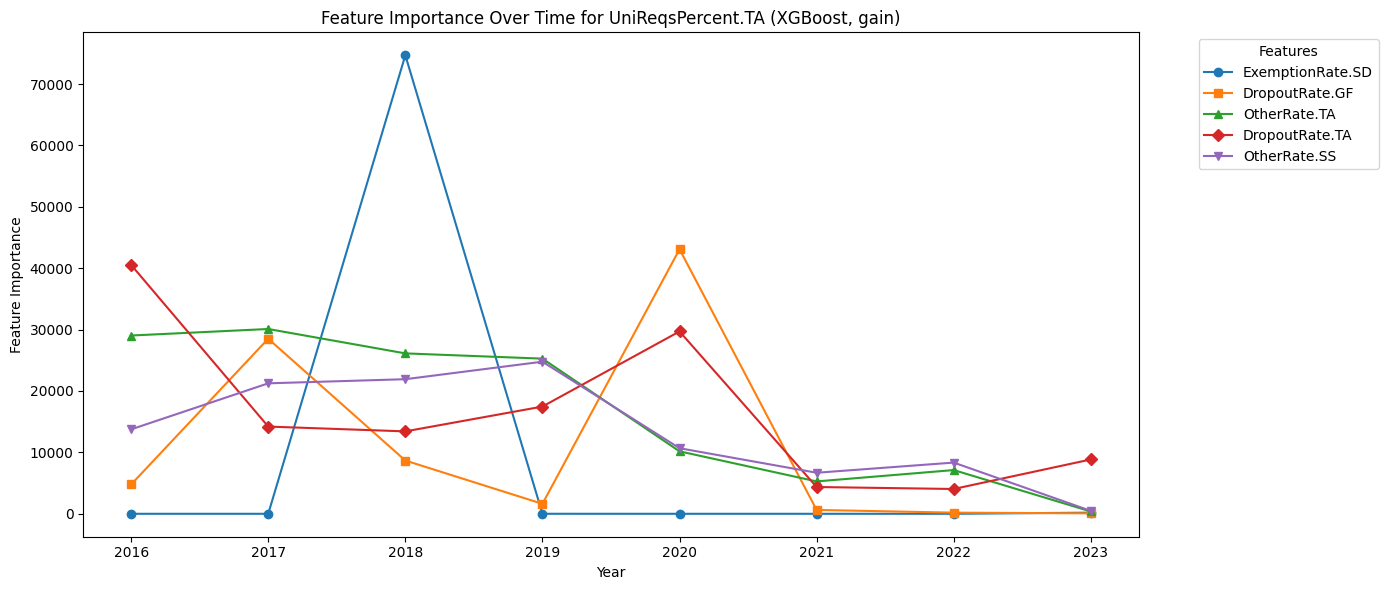

In [10]:
xgb.plot_feature_avg_variance(all_csu_rate_models, xgb_model, "gain", uc_csu_rate)
top_k_features = xgb.plot_top_k_features(
    all_csu_rate_models, xgb_model, "gain", uc_csu_rate, k=5
)
xgb.plot_feature_time_series(
    all_csu_rate_models, xgb_model, "gain", uc_csu_rate, top_k_features
)

## Random Forest


### Cross Validated Grad Rate


In [11]:
from modeling.utils.randomforest import (
    cross_validate_random_forest,
    plot_cv_feature_importance_rf,
    plot_top_k_features_rf,
    plot_feature_avg_variance_rf,
    plot_feature_time_series_rf,
)

cv_models = {}

target_variable = "RegHSDiplomaRate.TA"
years = list(year_df_mapping.keys())

for year in years:
    df = year_df_mapping[year]

    cv_result = cross_validate_random_forest(
        df=df,
        target_column=target_variable,
        columns_to_drop=grad_rate_columns_to_drop,
        n_splits=5,
        print_results=False,
    )

    cv_models[year] = cv_result

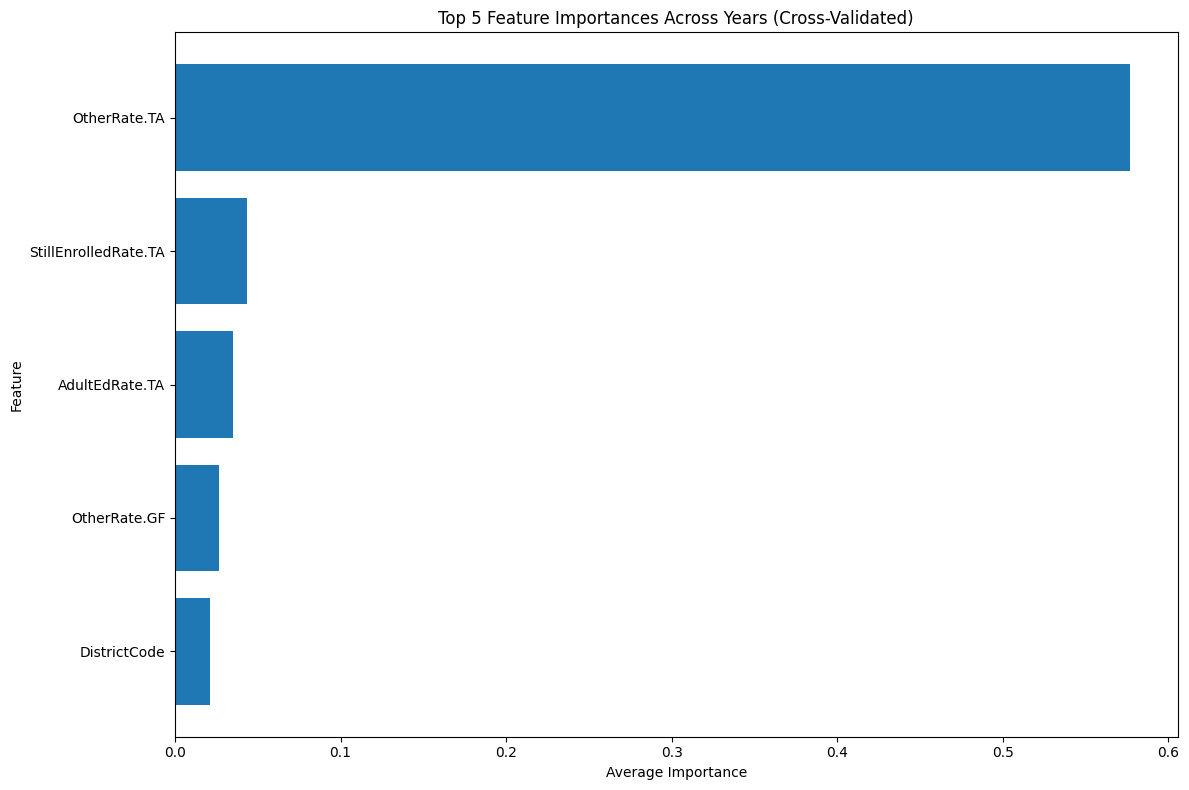

<Figure size 1400x600 with 0 Axes>

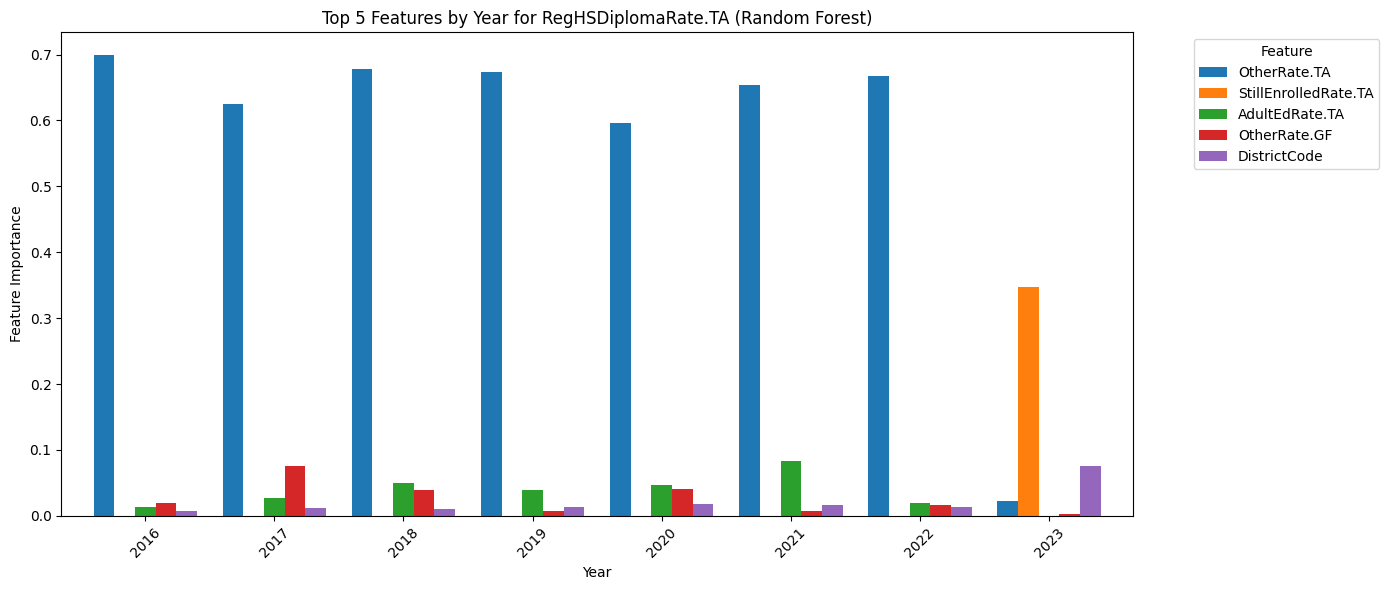

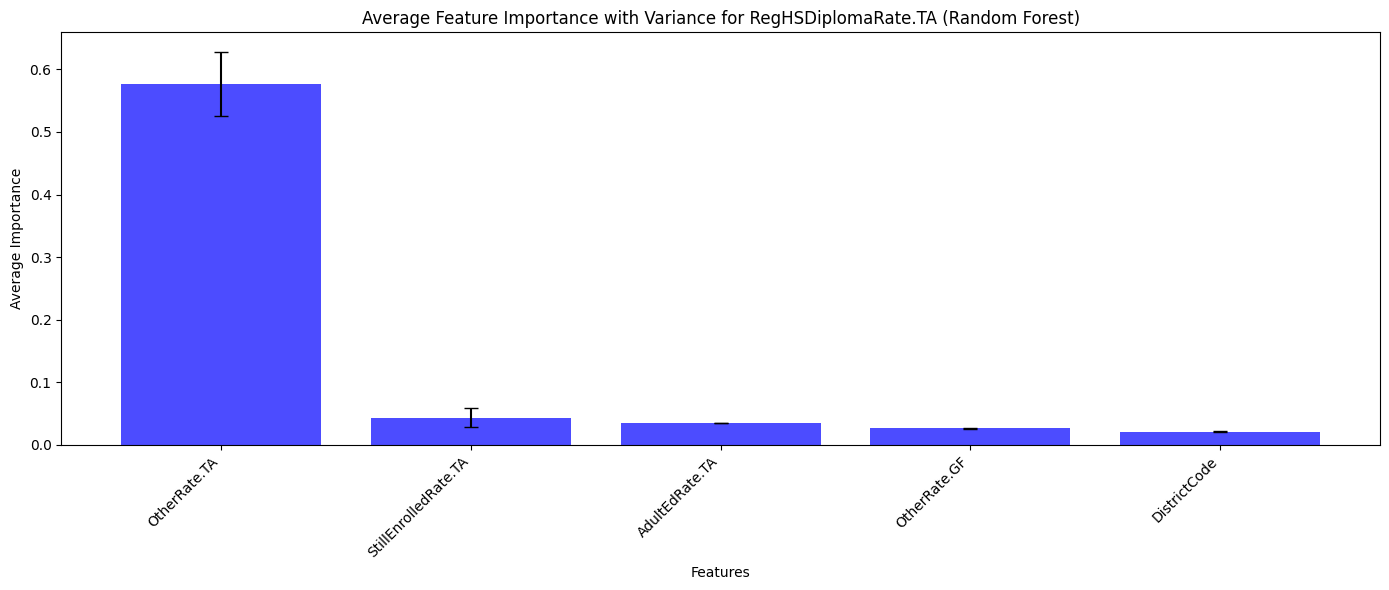

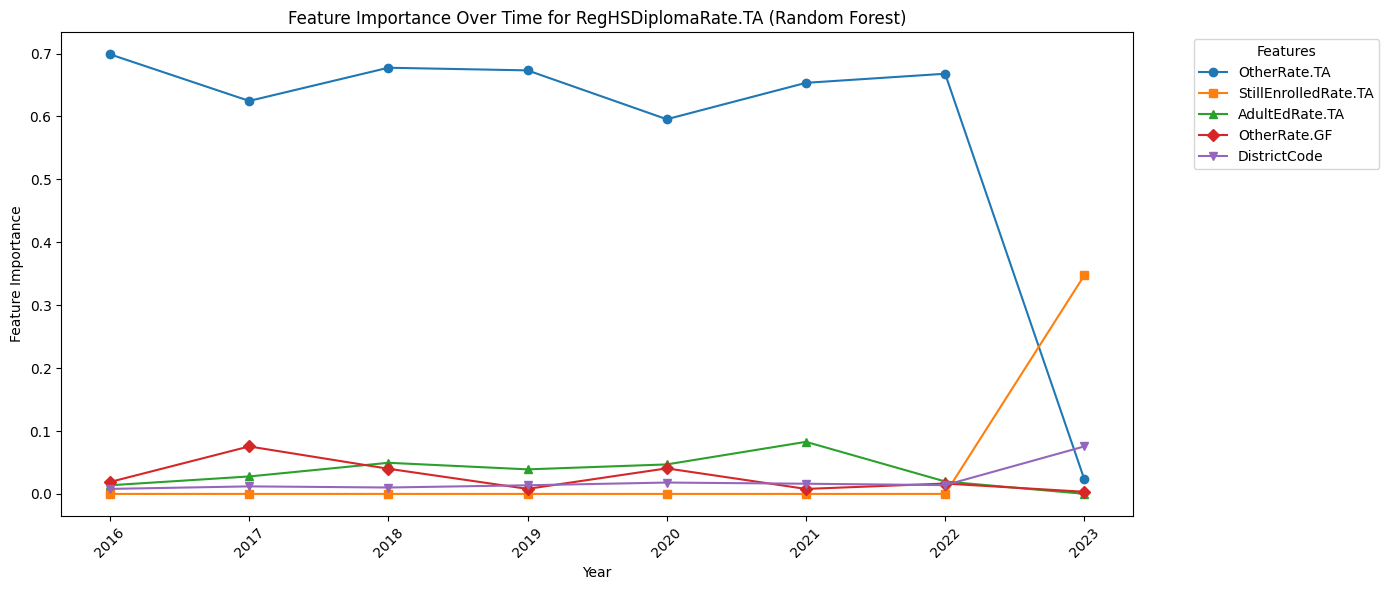

In [12]:
all_top_features = plot_cv_feature_importance_rf(cv_models, top_n=5)


plot_top_k_features_rf(cv_models, target_variable=target_variable, k=5)
plot_feature_avg_variance_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features[:5]
)
plot_feature_time_series_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features[:5]
)

### Cross Validated CSU/UC Readiness Rate


In [13]:
from modeling.utils.randomforest import (
    cross_validate_random_forest,
    plot_cv_feature_importance_rf,
    plot_top_k_features_rf,
    plot_feature_avg_variance_rf,
    plot_feature_time_series_rf,
)

cv_models = {}

target_variable = "UniReqsPercent.TA"
years = list(year_df_mapping.keys())

for year in years:
    df = year_df_mapping[year]

    cv_result = cross_validate_random_forest(
        df=df,
        target_column=target_variable,
        columns_to_drop=grad_rate_columns_to_drop,
        n_splits=5,
        print_results=False,
    )

    cv_models[year] = cv_result

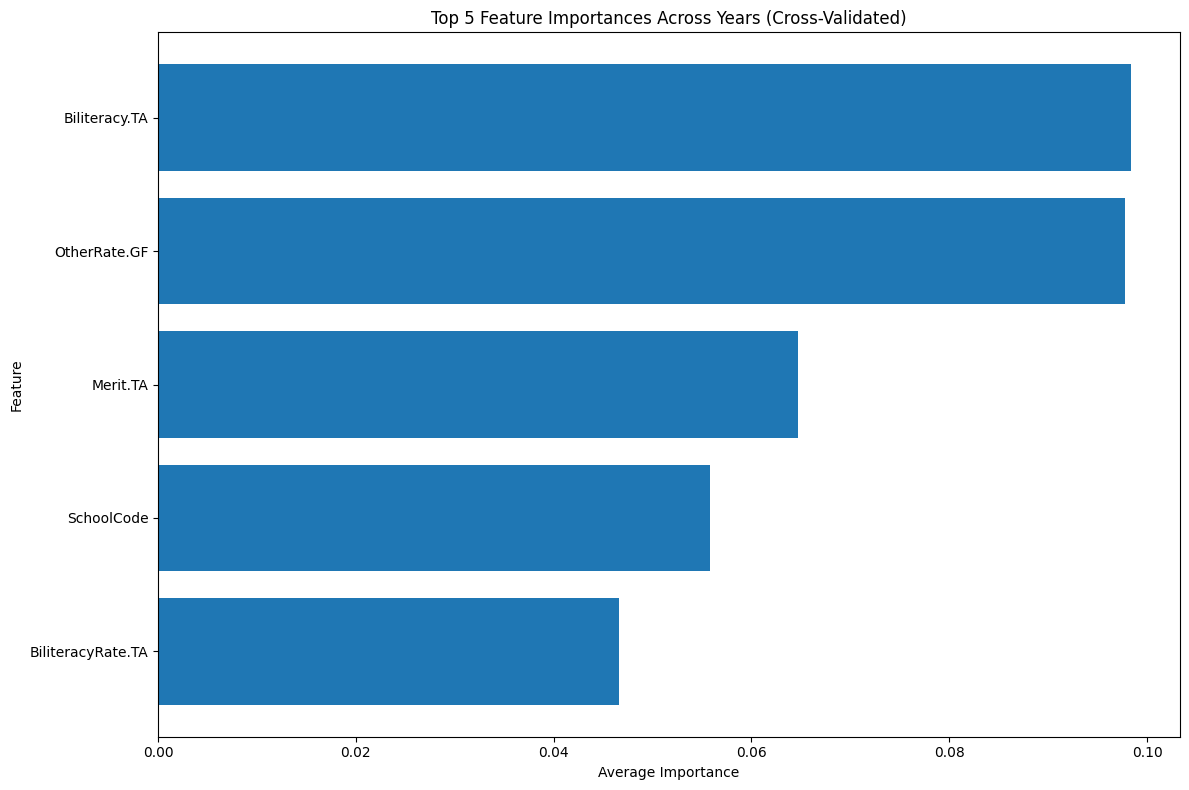

<Figure size 1400x600 with 0 Axes>

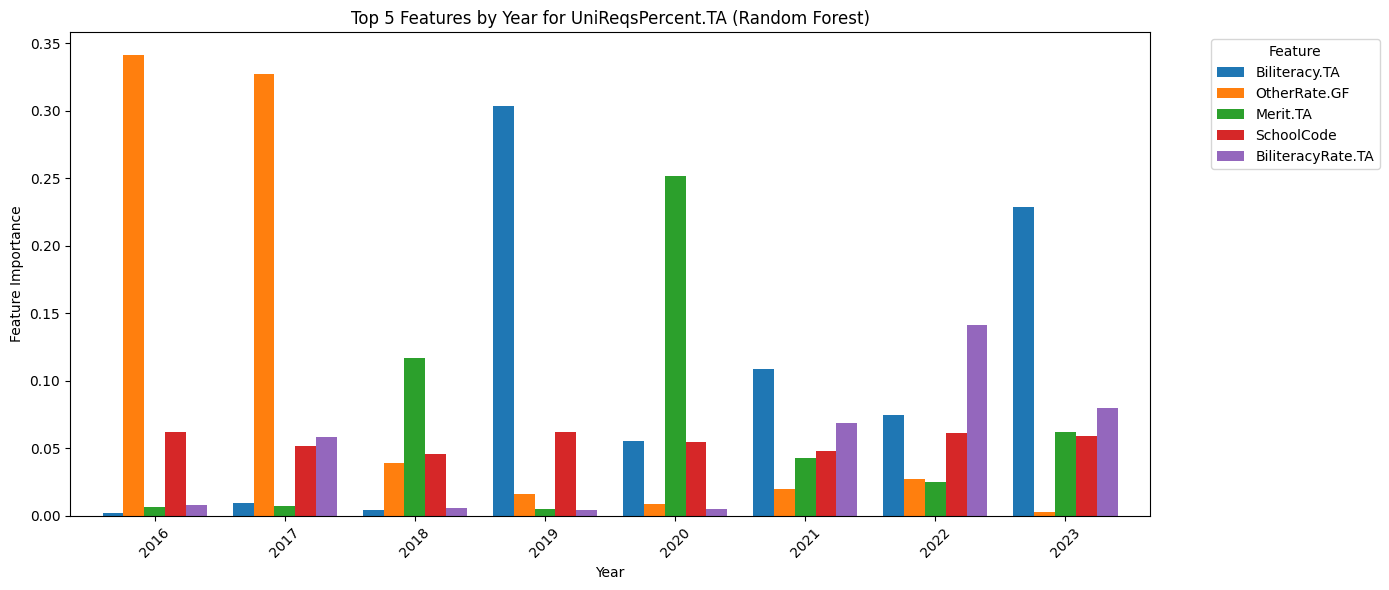

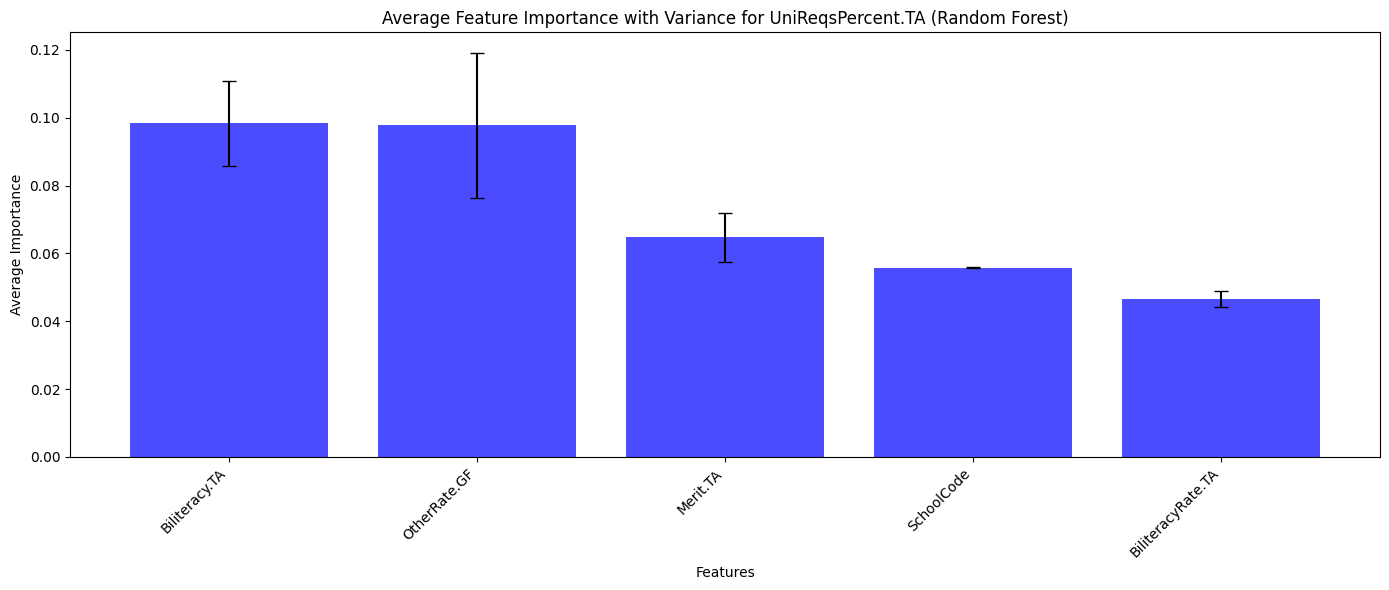

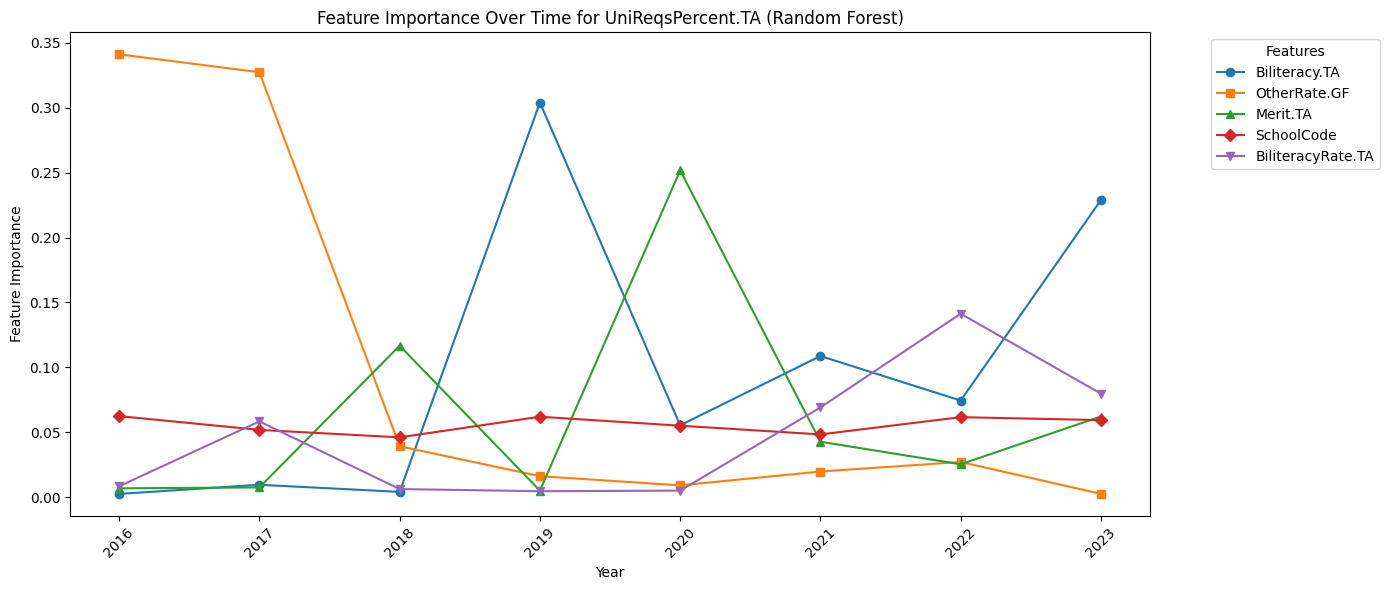

In [14]:
all_top_features = plot_cv_feature_importance_rf(cv_models, top_n=5)
plot_top_k_features_rf(cv_models, target_variable=target_variable, k=5)
plot_feature_avg_variance_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features[:5]
)
plot_feature_time_series_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features[:5]
)

### Non Cross-Validated Grad Rate


In [15]:
import modeling.utils.randomforest as rf

grad_rate = "RegHSDiplomaRate.TA"

all_rf_grad_rate_models = {}
for year, df in year_df_mapping.items():
    all_rf_grad_rate_models[year] = rf.train_random_forest_model(
        df, grad_rate, grad_rate_columns_to_drop, print_plot=False
    )

<Figure size 1400x600 with 0 Axes>

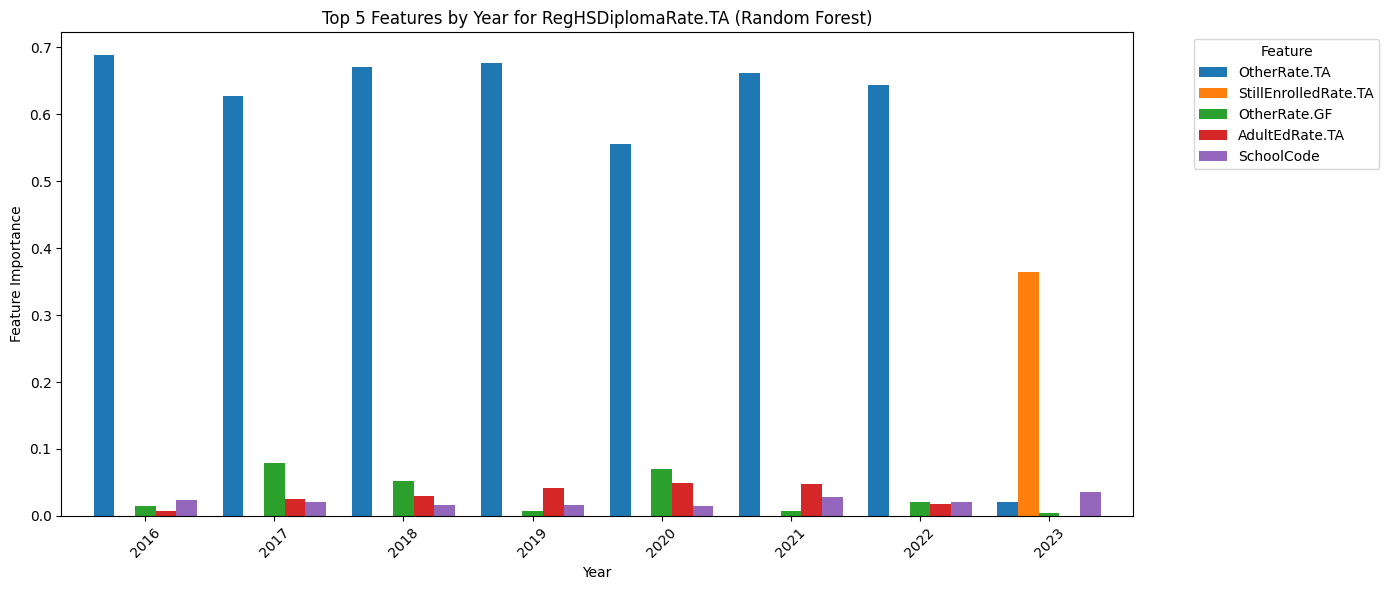

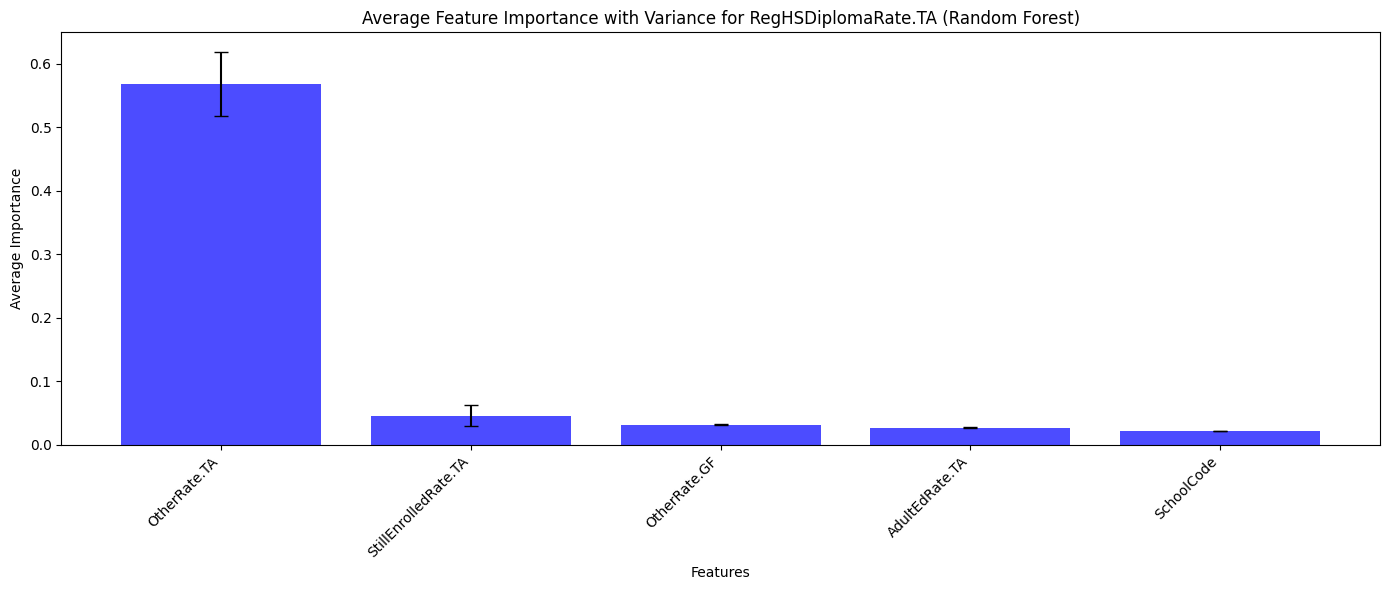

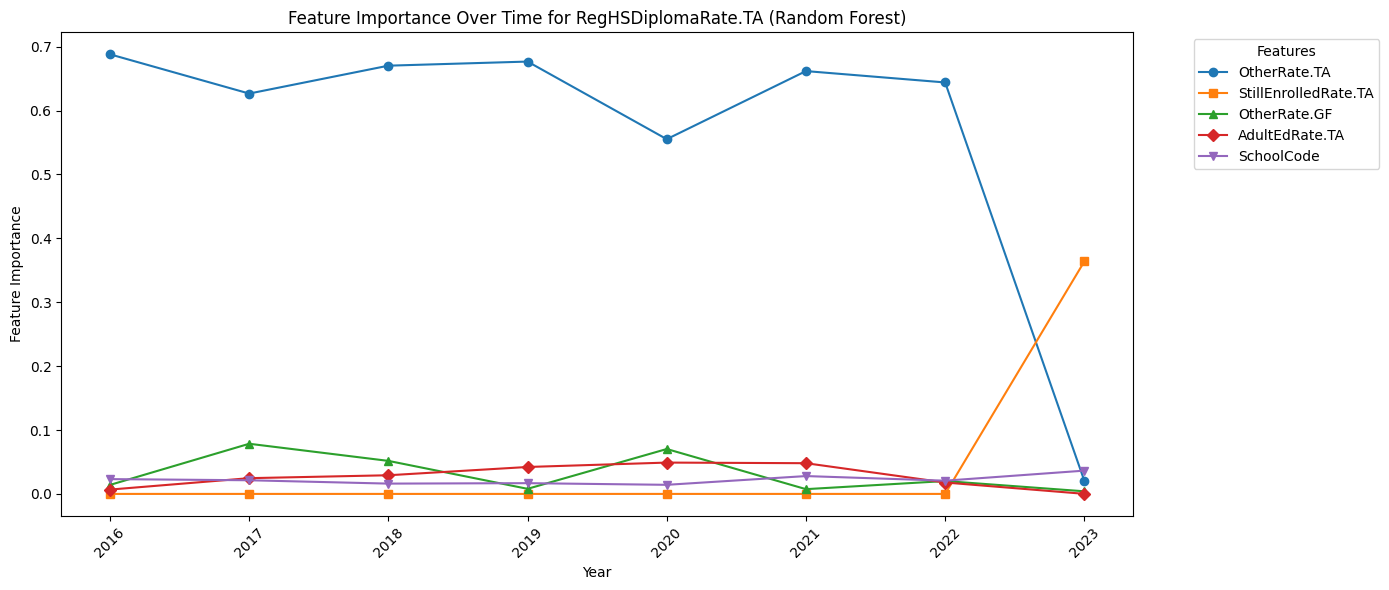

In [16]:
top_k_features_rf = rf.plot_top_k_features_rf(all_rf_grad_rate_models, grad_rate, k=5)

rf.plot_feature_avg_variance_rf(all_rf_grad_rate_models, grad_rate, top_k_features_rf)

rf.plot_feature_time_series_rf(all_rf_grad_rate_models, grad_rate, top_k_features_rf)

### Non Cross-Validated CSU/UC Readiness Rate


In [17]:
import modeling.utils.randomforest as rf

csu_uc_rate = "UniReqsPercent.TA"
rf_model = "RandomForest"

all_rf_csu_uc_rate_models = {}
for year, df in year_df_mapping.items():
    all_rf_csu_uc_rate_models[year] = rf.train_random_forest_model(
        df, csu_uc_rate, csu_rate_columns_to_drop, print_plot=False
    )

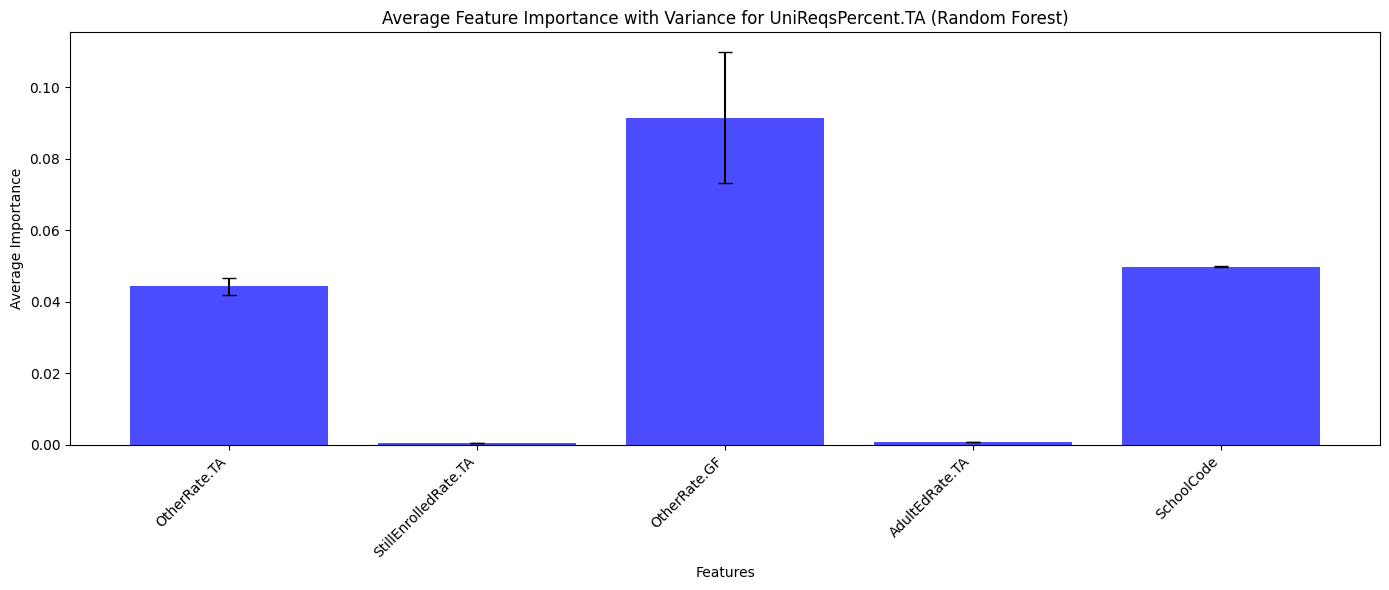

<Figure size 1400x600 with 0 Axes>

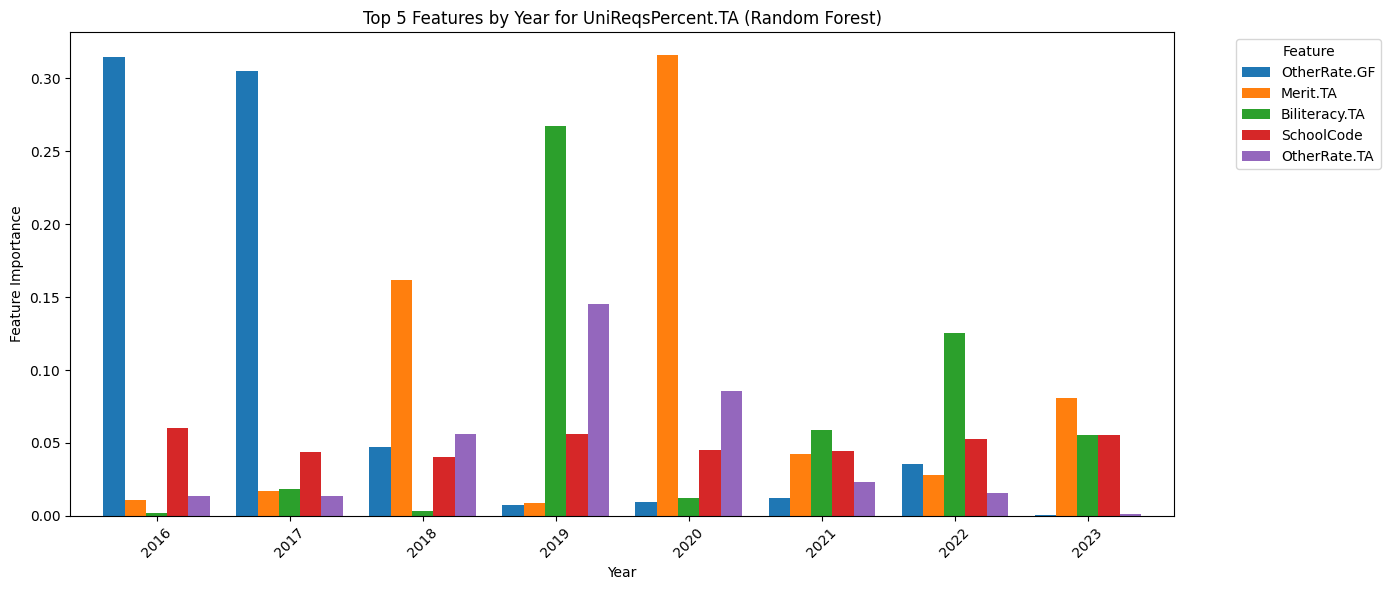

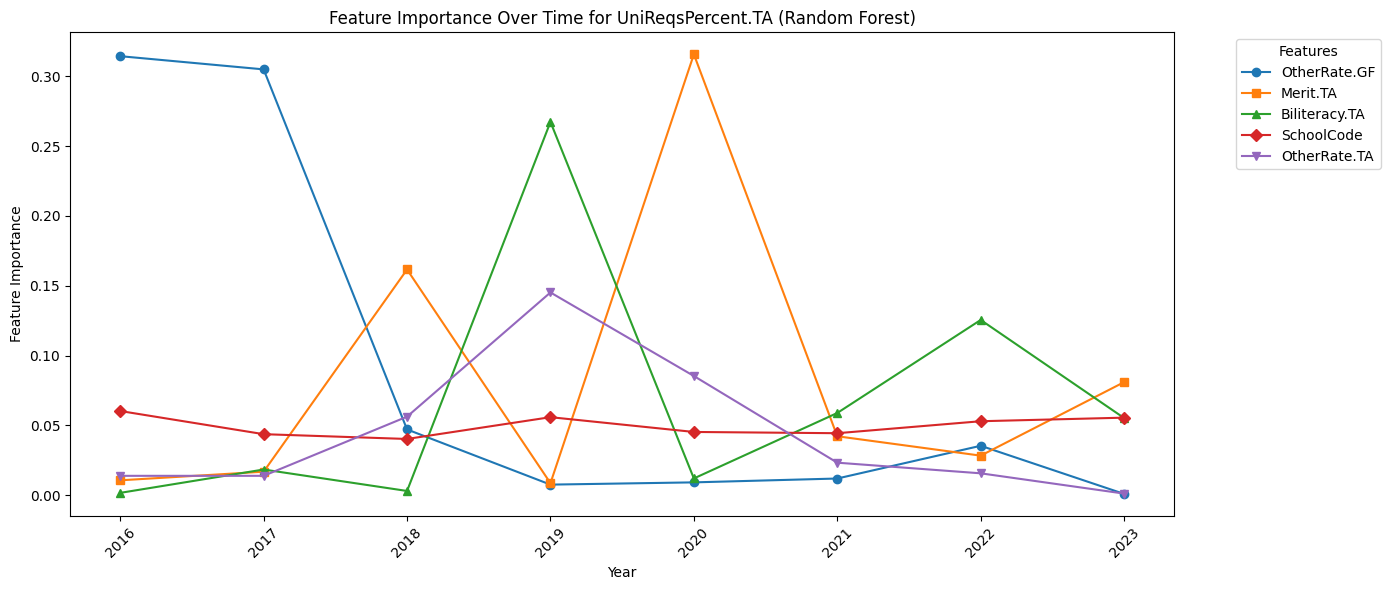

In [18]:
rf.plot_feature_avg_variance_rf(
    all_rf_csu_uc_rate_models, csu_uc_rate, top_k_features_rf
)
top_k_features_rf = rf.plot_top_k_features_rf(
    all_rf_csu_uc_rate_models, csu_uc_rate, k=5
)
rf.plot_feature_time_series_rf(all_rf_csu_uc_rate_models, csu_uc_rate, top_k_features_rf)

In [19]:
con.close()